# Projet Notations de films 

Dans le cadre du Projet Data Science nous avons choisi d'étudier l'appréciation des films par les spectateurs et la presse (caractérisée par une note) en fonction de leur caractéristiques (genre, durée, récompenses, etc). Nous nous demandions si certaines caractéristiques de films font qu'ils sont mieux notés ? Est-ce que certains genres de films sont plus appréciés que d'autres ? Est-ce que la presse et les spectateurs réagissent de manière similaire ? Est-ce que le genre du réalisateur d'un film peut avoir un lien sur les notes qui lui sont attribuées ?

Pour cela nous nous nous basons sur la base Allociné et base française CNC.

Le rapport se décompose de la manière suivante :   

I - Création de la base de données

1) Base Allociné  

2) Base CNC


II - Analyses descriptive des données

1) Analyses générales sur les notes attribuées aux films en fonction du genre du films

2) Analyses sur d'autres variables

3) Comparaison appréciation spectateurs vs presse

4) Analyses plus subtiles sur le genre et le budget à partir de la base CNC


III - Modélisation

1) Peut-on prédire les notes des spectateurs à partir de caractéristiques des films ?

2) Peut-on regrouper les presses en fonction de leur appréciations aux divers films ?


In [1]:
# Importation des librairies
import csv
import os
import s3fs

# 
import matplotlib.pyplot as plt
import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re
import nest_asyncio
import numpy as np

In [ ]:
# # # Installation des packages nécessaires au projet        A supprimer avant d'envoyer  
!pip install ipywidgets

!pip install lxml
!pip install aiohttp
!pip install nest_asyncio
!pip install unidecode

!pip install \
    ipywidgets \
    lxml \
    aiohttp \
    nest_asyncio \
    unidecode \
    matplotlib \
    pandas \
    numpy \
    beautifulsoup4 \
    statsmodels \
    scikit-learn \
    seaborn \
    openpyxl \
    plotly \
    s3fs

In [2]:
# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")

for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")


for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### 1) Base AlloCiné

Pour répondre à notre problématique, nous avons besoin de données sur les films (notes, budget, etc.) et les réalisateurs. Pour obtenir les données nécessaires pour répondre à notre problématique, nous avons choisis de web scraper les données de Allociné. Un site français spécialisé sur le cinéma, donnant à un grand nombre d'informations sur un large spectre de film. Cependant le site n'a pas d’api publique, mais le site utilise des pages standardisées et non dynamiques (à l’inverse de site comme linkedin), simplifiant les étapes du web scraping. De plus, il existe des pages regroupant tous les films selon une année/décennie ou un genre. Le web scraping, est l'extraction automatisée d’informations provenant des pages d'un site web à l'aide d'un programme tiers.

Cependant, cette méthodologie nécessite de web scraper un nombre important de pages avec plusieurs milliers de lignes de code, rallongeant la durée d'exécution des programmes. Ce problème peut être résolu en utilisant du web scraping asynchrone. Le principale mécanisme de cette démarche est d'exécuter plusieurs requêtes en même temps, permettant des gains de temps. Cependant un nombre important de requêtes pourrait être interprété comme une attaque DDOS par le site, mais cette méthode n’effectue qu’une dizaine de requêtes par secondes contre plusieurs centaines de milliers pour une attaque par dénis de service. 
Ce dernier point, ouvre une question plus globale, celle de la légalité, en effet la création de ces données est coûteuse pour allociné, de plus le doit financer un infrastructure réseaux. Alors qu’en parallèle les web scrapeurs ne versent pas de compensations au site. Cependant, l’article L. 342-3 du Code de la propriété intellectuelle, dispose que le web scrapping est légal das le cas d'une utilisation à des fins de recherche ou pédagogique.

Le scraping classique fonctionne de manière séquentielle, envoyant une requête à la fois et attendant une réponse avant de continuer, ce qui le rend simple à implémenter mais lent pour des volumes de données importants. En revanche, le scraping asynchrone permet d’envoyer plusieurs requêtes simultanément, optimisant ainsi les temps d’exécution. 




Le processus de web scraping est effectué année par année. Les liens des films sont récupérés uniquement s'il existe des critiques de presse pour ces films. Dans ce cas, les caractéristiques des films sont également collectées. Seuls les films ayant des notes de presse sont disponibles, ce qui permet d'éviter de scraper inutilement des pages sans contenu pertinent.

In [ ]:
# Récupération d'une liste de films possédant tous une note moyenne de SPECTATEUR et une note moyenne de PRESSE 
# avec plusieurs caractéristiques : titre, durée, nom du réalisateur, etc

# Exemple de webscrapping d'UNE année (temps estimé à moins de 2 minutes)
table_wbs_exemple = get_base_final(2011,2012)

La base générée par webscrapping et utilisée dans le rapport comprend les films de **2001** à **2024**, pour lesquels nous avons au moins la moyenne des spectateurs et la note moyenne attribuée par la presse. La construction de cette table prenant une vingtaine de minutes (et son contenu pouvant varier en fonction du moment où a lieu le webscrapping), une fois générée, la table a été enregistrée au sein du SSP Cloud.

In [4]:
# Lecture de la base CSV (sauvegardée dans le SSP Cloud car webscrapping qui prend un peu de temps (et les données changent régulièrement)) :

# Création du chemin
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "roux"
fs.ls(MY_BUCKET)
chemin = f"{MY_BUCKET}/base_final_v2.csv"

# Importation
with fs.open(chemin, "r") as file_in:
    table_films = pd.read_csv(file_in)

**Si le code précédent ne fonctionne pas (mettre à jour les jetons, ou bien dé-commenter et exécuter le code suivant) :**

In [9]:
# Si ne fonctionne pas 
url = "https://minio.lab.sspcloud.fr/roux/base_final_v2.csv"
import pandas as pd
table_films = pd.read_csv(url)

Traitement de la base Allociné (Mise en forme et création de variables)

In [5]:
####### Nettoyage et mise en forme

# Conversion des notes en écriture décimale
table_films['spectators_rating'] = table_films['spectators_rating'].apply(mise_en_forme_decimale)
table_films['press_rating'] = table_films['press_rating'].apply(mise_en_forme_decimale)



######## Créations de variables

# Ajout du genre des réalisateurs (en se basant sur une base de plus de 11 627 prénoms de plusieurs pays dont le genre est mentionné)
table_films = get_genre_individuel(table_films, 'director')


# Année du film
table_films = get_annee(table_films, 'date')               

# Durée du film en minutes
table_films['duration'] = table_films['duration'].astype('string')
table_films['duration_min'] = table_films['duration'].apply(duree_en_minutes)

# Variable catégorielle du type de récompenses (prix, nomination, rien)
table_films['categorie_recompenses'] = table_films['recompenses'].apply(get_cat_recompenses)

# Récupération du nombre de nominations et nombre de prix par film
table_films[['prix', 'nominations']] = table_films['recompenses'].apply(lambda x: pd.Series(get_laureat_nomination(x)))
 

# Création d'un dataframe, contenant les notes de chaque film par presse + Traduction des notes en numérique (Très bien => 4, etc)
presse = table_films.iloc[:, [1] + list(range(27, 80))]
presse_notes = equivalence_notes(presse)
presse_notes.set_index('identifiant', inplace=True)



/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


In [6]:
print('La table Allociné contient', len(table_films), 'films')

La table Allociné contient 10837 films


### 2) Base CNC

Afin d'enrichir nos données, nous avons décider de nous appuyer également sur la base CNC (Centre National du cinéma) française.

In [12]:
# récupération de la base CNC par API
#Ici, j'importe les données du CNC en utilisant un API.
import requests
import pandas as pd
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() #je mets tout dans un dico json
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 
#films_cnc = films_cnc.set_index('visa')

b'[{"visa": "117042", "titre": "BYE BYE BLONDIE", "realisateur": "DESPENTES Virginie", "producteurs": "MASTER MOVIES / RED STAR CINEMA / WILD BUNCH", "devis": 4103906.0, "genre": "Fiction", "eof": null, "rang": "2", "asr": "avant", "payante": null, "clair": null, "nationalite": ["France", "Belgique", "Suisse"], "date": "2010", "decomposition": "France-65 / Belgique-21 / Suisse-14", "aides": ["Sofica"]},{"visa": "127028", "titre": "DE L\'HUILE SUR LE FEU", "realisateur": "BENAMOU Nicolas", "producteurs": "AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / TF1 DROITS AUDIOVISUELS / UGC IMAGES", "devis": 3320336.0, "genre": "Fiction", "eof": null, "rang": "1", "asr": null, "payante": null, "clair": null, "nationalite": ["France"], "date": "2010", "decomposition": "France-100", "aides": ["Sofica", "Cr\\u00e9dit D\'impot"]},{"visa": "124421", "titre": "DES JEUNES GENS MODERNES", "realisateur": "DE MISSOLZ J\\u00e9r\\u00f4me", "producteurs": "ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRODUCTIONS

In [13]:
# Categorisation des films en fonction du devis
films_cnc = categorisation_devis(films_cnc)

# Ajout d'une variable de genres : attention, cela prend 3 minutes
films_cnc = ajout_genre_multiple(films_cnc, 'realisateur')


======== fusion avant

In [14]:
#Fusion base CNC et base allociné 
base_allocine = table_films.drop(columns=['titre', 'genre_ind'])
base_cnc_agregee = pd.merge(films_cnc, base_allocine,left_on='visa', right_on='num_visa', how='inner')
len(base_cnc_agregee)

2843

In [ ]:
#INUTILE ??
# Conversion des notes en écriture décimale

base_cnc_agregee['spectators_rating']= base_cnc_agregee['spectators_rating'].apply(mise_en_forme_decimale)
base_cnc_agregee['press_rating'] = base_cnc_agregee['press_rating'].apply(mise_en_forme_decimale)


## II -  Analyses descriptives

### 1) Analyses descriptives générales des notes des spectateurs en fonction du genre du film

Nous avons à notre disposition une base de **10 837** films issus d'Allocinés. Avec pour chaque film la **note moyenne** attribuée par les **spectateurs** ainsi que la note moyenne attribuée par **la presse**. Les notes vont de **1 à 5**.

1) Dans un premier temps, nous pouvons regarder quels sont les types de films les plus appréciés en moyenne par les spectateurs : 

In [7]:
# (A noter que les genres dont nous possédons moins de 50 films ne sont pas pris en compte).
classement_genres_preferes(table_films, 'spectators_rating')

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.41,345
Animation,3.25,509
Drame,3.11,4143
Aventure,3.07,568
Policier,3.02,342
Comédie dramatique,2.95,891
Action,2.91,954
Science Fiction,2.85,50
Thriller,2.79,257


Les films **Biopic**, d'**Animation** et **Drame** semblent être les plus appréciés par les spectateurs. Tandis que les films de **Comédie**, **Fantastique** ou encore d'**Epouvante-horreur** semblent relativement moins appréciés. 

A noter que les effectifs au sein de chaque genre de films peuvent être assez variables (allant de 50 pour la Science Fiction à plus de 4143 pour les Drames). De ce fait, il peut être intéressant de comparer de manière plus précise les **notes moyennes** attribuées par les **spectateurs** afin de voir si les différences dans la **notation des spectateurs** en fonction du **genre de film** sont significatives ou pas. 

Pour cela, nous pouvons regarder la distribution des notes à l'aide d'un **histogramme**, et réaliser un test **ANOVA** sur les différents groupes. Cette méthode statistique permet de déterminer si au moins une des moyennes parmi les groupes étudiés est significativement différente des autres, en tenant compte de la variabilité au sein et entre les groupes.

Dropdown(description='Genre 1 :', index=12, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aven…

Dropdown(description='Genre 2 :', index=12, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aven…

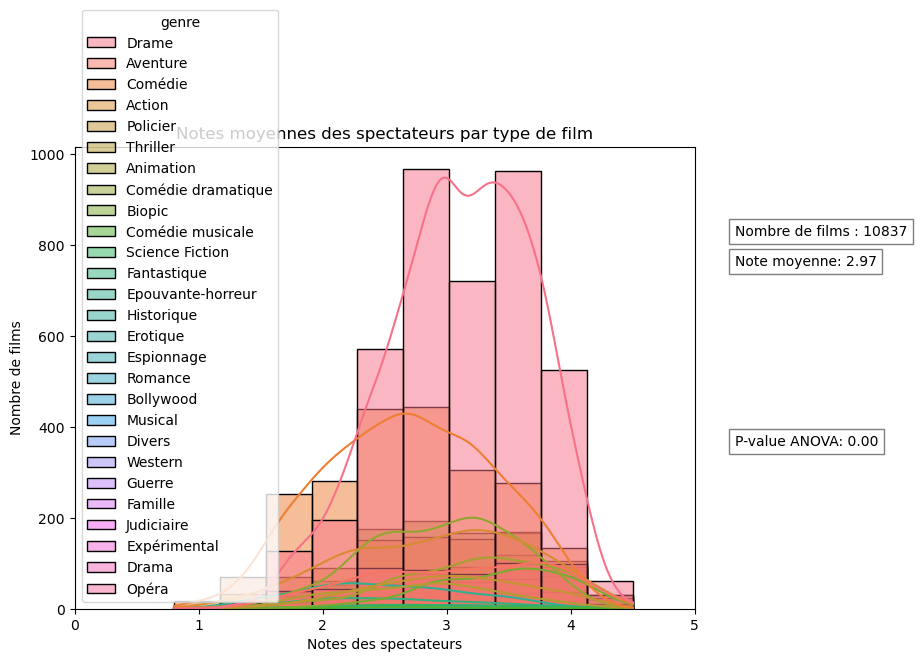

In [ ]:
# Histogrammes de la distribution des notes attribuées par les spectateurs en fonction du genre du film
# => Les menus déroulants permettent de sélectionner différents genres à comparer 
# => Les genres dont nous possédons moins de 50 films ne sont pas pris en compte)                    

menu_deroulant_histogramme(table_films,'genre1')                   

Une p-value du test d'ANOVA très faible (inférieure aux seuils usuels, et notamment de 5%), indique que la différence de notation des spectateurs entre les genres de films peut être considérée comme significative. En étudiant les différentes distributions de notes en fonction des genres ainsi que les tests ANOVA associés, nous pouvons remarquer les points suivants :


- L'ANOVA sur tous les types de films (**p-value < 0.01**) montre qu'il existe bien des **différences significatives** au sein des groupes (au moins un groupe se distingue des autres), cependant cela ne donne aucune information sur quels sont les groupes statistiquement significatifs. Pour cela, nous pouvons par exemple les comparer deux par deux. 


- Pour certains genres de films qui étaient très proche dans le classement, leur p-value montrent que les différences de notations ne sont pas très significatives (Tels que **Action** et **Comédie Dramatique** avec 0,19), voir pas du tout significatives (avec des valeurs de p-value supérieures à 0,6 pour SF et Action par exemple).

- Mais certains genres qui étaient très proches au niveau de la notation moyenne, se retrouvent à avoir des différences de notation qui peuvent être considérées comme statistiquement significatives. C'est notamment le cas du genre **Animation** et **Aventure**, respectivement aux deuxième et troisième places, significatives au seuil de 1%.

- Bien sûr, comme attendu, nous remarquons que plus les 2 genres considérés sont éloignés dans le classement, plus la p-value est significative. 

Les diverses ANOVA réalisées laissent supposer que le type de films semblerait avoir un lien avec la note attribuée par les spectateurs.

### 2) D'autres caractéristiques pourraient-elles avoir une influence sur l'appréciation attribuée par les spectateurs ?

De manière similaire à précédemment nous pouvons effectuer un test **ANOVA** sur le **genre du réalisateur** afin de voir s'il existe une différence significative dans les notes moyennes attribuées aux films réalisés par des femmes et aux films réalisés par des hommes.

In [8]:
p_value_anova_h_vs_f(table_films)

'P-value du test ANOVA: 0.241'

Avec une p-value bien supérieure aux seuils habituels de 1, 5 et 10%, nous pouvons dire qu'il ne semble **pas** y avoir de **différence** statistiquement significative entre les notes attribuées par les spectateurs pour des films réalisés par des femmes et des films réalisés par des hommes. 

Nous pouvons aussi nous pencher sur la durée des films, en traçant le boxpolt des notes en fonction de la durée des films (durées qui ont été discrétisées en intervalle de 10 minutes) : 

/home/onyxia/work/Projet_Cin-/B_Analyse_descriptive/Fonctions_diverses.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['duree_cat'] = pd.cut(dataframe[variable], bins=bins, labels=labels, right=False)


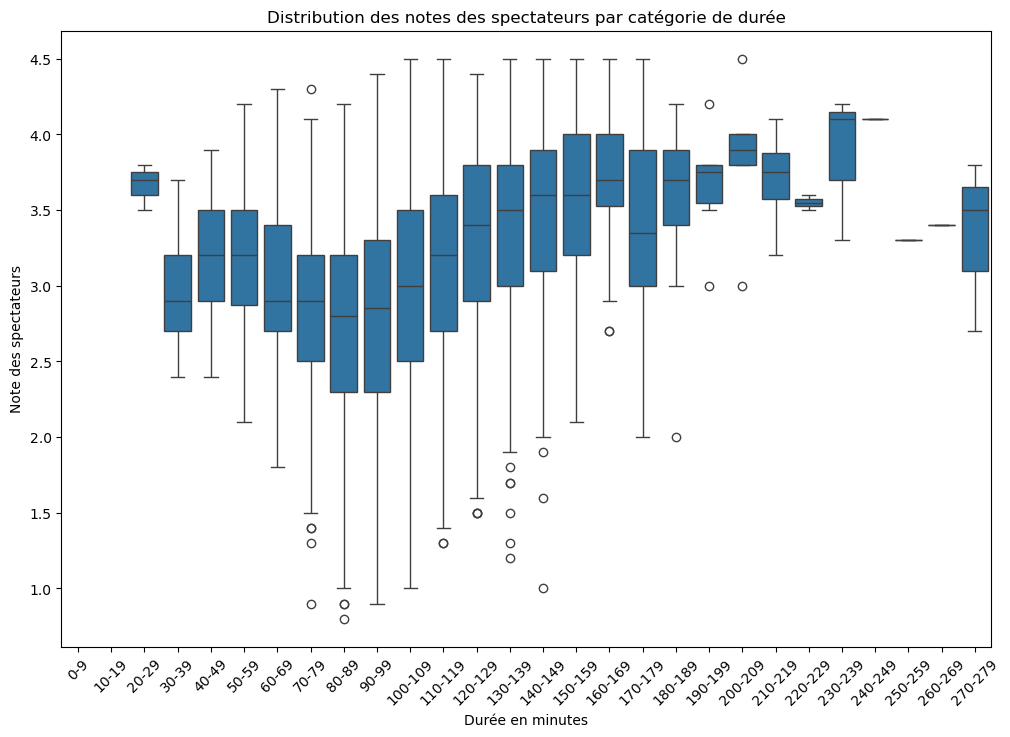

In [ ]:
boxplot_duree(table_films, 'duree_cat')

Le boxplot laisse entrevoir deux tendances linéaires : 
- décroissante pour les films de courtes durées jusqu'à 80 minutes
- croissante pour les films avec des durées supérieures à 80 minutes

Cependant, ces tendances ne semblent pas statistiquement significatives.

En se basant sur les récompenses obtenus par les films, nous pouvons regarder la moyenne de la note attribuée aux films qui ont :
- Au moins un prix (éventuellement aussi des nominations)
- Une ou des nominations (mais pas de prix)
- Ni prix, ni nominations

In [10]:
get_moyenne_par_modalite(table_films, 'categorie_recompenses')

,presse,spectateur
categorie_recompenses,,
aucune récompense,2.95,2.86
nominations,3.16,2.99
prix,3.47,3.31


Nous remarquons que plus les films ont de meilleures récompenses (prix > nominations > rien), plus la note moyenne attribuée par les spectateurs est élevée.

### 3) Les préférences des spectateurs sont-elles similaires à celles de la presse ?

Nous avons précédemment regardé le classement des genres de films les plus appréciés par les spectateurs. Comparons maintenant ce classement à celui de la presse :

In [11]:
comparaison_preferences(table_films)

,Note_Moyenne,Nombre_de_Films
genre,,
Biopic,3.41,345
Animation,3.25,509
Drame,3.11,4143
Aventure,3.07,568
Policier,3.02,342
Comédie dramatique,2.95,891
Action,2.91,954
Science Fiction,2.85,50
Thriller,2.79,257


Le classement se ressemble avec un même quatuor en tête, et même genres de films en queue de classement. 
Cependant les notes moyennes des spectateurs semblent tenir globalement sur un intervalle plus large que celui de la presse.

Dropdown(description='Genre :', index=2, options=('Drame', 'Comédie', 'Action', 'Comédie dramatique', 'Aventur…

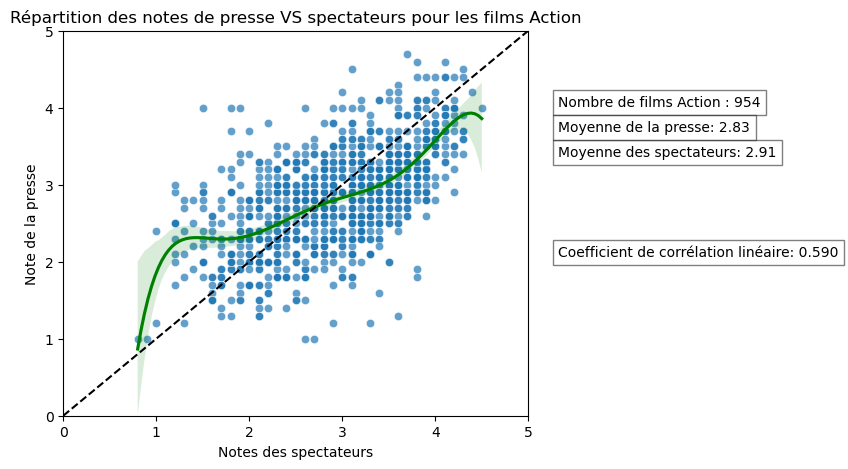

In [ ]:
# Nuage de points pour voir les différences de notations entre la presse et les spectateurs
# => Pour chaque graphique, un polynôme en vert représente le polynôme optimal (degré max 6) 
# => Comparer ce poynôme avec la droite x = y (en pointillé) permet de voir si les notes de la presse
# et des spectateurs sont proches ou non
graphique_presse_vs_spect(table_films) 

Pour la plupart des genres de film, nous pouvons observer une **nette plus grande dispersion** des notes des **spectateurs** par rapport à celles de la **press**e. Ce qui refléterait la nature plus **hétérogène/polaire/subjective** des évaluations des spectateurs comparées aux critiques de la presse.

Avec un coefficient de corrélation linéaire de 0,53 (en prenant en compte tous les films), nous avons une **relation positive modérée** entre les notes de la presse et des spectateurs. Nous avons une influence modérée des critiques de presse sur les opinions des spectateurs.

En regardant par type de film, nous nous apercevons que nous pouvons distinguer 3 catégories de films :
- Les films un peu plus corrélés que la moyenne des films (corrélation entre 0,6 et 0,7 pour Aventure, Animation, Epouvante Horreur et Science Fiction)
- Les films corrélés dans la moyenne des films (Policier, Thriller, Comédie et Action)
- Les films très peu corrélés (Comédie dramatique, Biopic, Fantastique et Drame)


Afin d'avoir une analyse plus fine, notamment en terme de budget alloué au film ainsi que le genre du/des réalisateurs nous pouvons agréger à nos films, la base française CNC. Nous perdrons un certains nombre de films, mais en contrepartie cela nous permet d'avoir des variables plus précises pour certaines caractéristiques : notamment sur le(s) genre(s) des réalisateurs ainsi que les budgets alloués aux films.

### 4) Le budget alloué et le genre des réalisateurs peuvent-ils influer sur les notes attribuées par la presse et les spectateurs ? (périmètre d'étude réduit aux films français de la base CNC)

### Base CNC : Analyse du type de devis

Une base du CNC nous donne ce type d'information : les sociétés productrices et distributrices des films, chaînes de télévision partenaires en préachat. Je veux étudier les différences de montant des devis selon le genre du réalisateur.


In [ ]:
Explication ++++++++++++

COMMENTAIRE !!!

In [ ]:
diagramme_baton_genre_proportion(base_cnc_agregee, "type_de_devis")

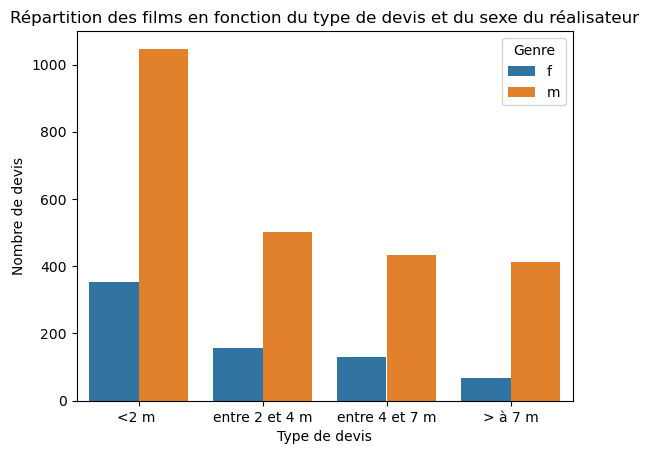

In [ ]:

# Filtrer les données pour les modalités 'f' et 'm' de 'genre_ind'
films_cnc_filtered = films_cnc[films_cnc['genre_ind'].isin(['f', 'm'])]

# Créer le barplot avec seaborn
sns.countplot(data=films_cnc_filtered, x='type_de_devis', hue='genre_ind', dodge=True)

# Ajouter des titres et des labels
plt.title('Répartition des films en fonction du type de devis et du sexe du réalisateur')
plt.xlabel('Type de devis')
plt.ylabel('Nombre de devis')
plt.legend(title='Genre')

# Afficher le plot
plt.show()

/home/onyxia/work/Projet_Cin-/B_Analyse_descriptive/Fonctions_diverses.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  moyenne = dataframe.groupby(variable).agg(


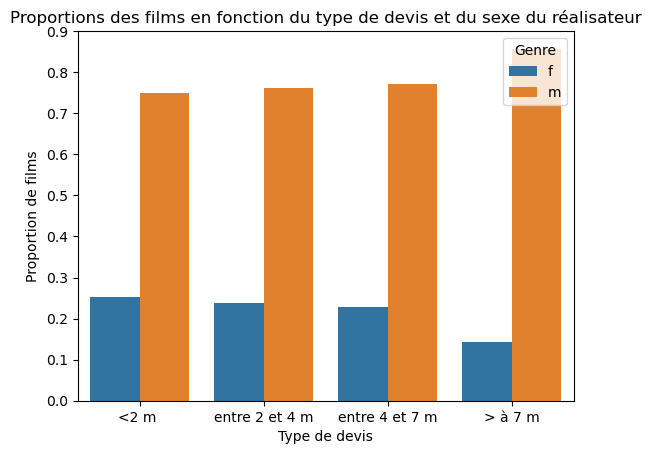

In [ ]:

# Filtrer les données pour les modalités 'f' et 'm' de 'genre_ind'
films_cnc_filtered = films_cnc[films_cnc['genre_ind'].isin(['f', 'm'])]

# Calculer les proportions pour chaque catégorie de type_de_devis et genre_ind
proportions = films_cnc_filtered.groupby(['type_de_devis', 'genre_ind']).size().unstack().fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)  # Normaliser par ligne (type_de_devis)

# Réorganiser les données pour un plot avec seaborn
proportions = proportions.reset_index().melt(id_vars=['type_de_devis'], value_name='Proportion')

# Créer le barplot avec seaborn
sns.barplot(data=proportions, x='type_de_devis', y='Proportion', hue='genre_ind')

# Ajouter des titres et des labels
plt.title('Proportions des films en fonction du type de devis et du sexe du réalisateur')
plt.xlabel('Type de devis')
plt.ylabel('Proportion de films')
plt.legend(title='Genre')

# Afficher le plot
plt.show()


### Fusion base CNC et base allociné

In [ ]:
#Comparaison avis spectateurs vs presse selon le type de devis
get_moyenne_par_modalite(base_cnc_agregee, "type_de_devis")

,presse,spectateur
type_de_devis,,
<2 m,3.116203,2.850199
entre 2 et 4 m,3.189173,2.832481
entre 4 et 7 m,3.126592,2.887079
> à 7 m,2.933669,2.783871


COMMENTAIRE

In [ ]:
#Part des films réalisés par les hommes ou les femmes dans chaque catégoeire de budget
diagramme_baton_genre_proportion(films_cnc, "type_de_devis")

In [ ]:
base_cnc_agregee["genre_ind"].value_counts()

genre_ind
m              1608
non trouvé      508
f               447
m_coréalisé     160
f_coréalisé      54
m,f              40
f,m              26
Name: count, dtype: int64

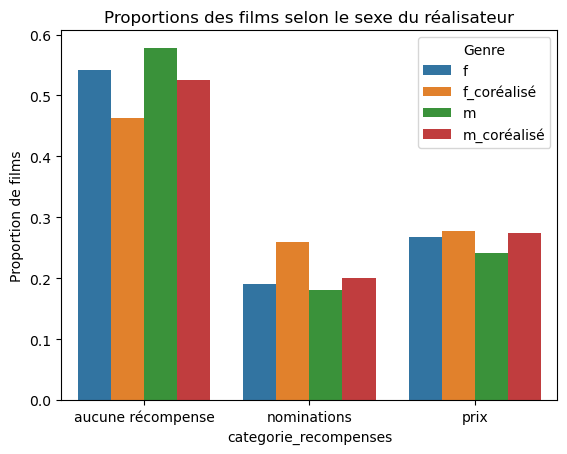

In [ ]:
diagramme_baton_genre_proportion(base_cnc_agregee, 'categorie_recompenses')

Dropdown(description='Genre du film :', index=9, options=('Drame', 'Comédie', 'Comédie dramatique', 'Aventure'…

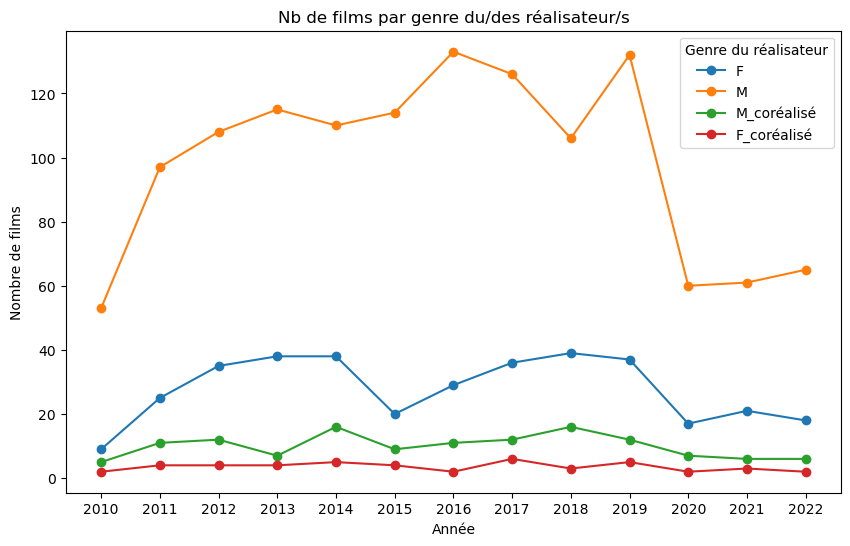

In [ ]:
# Evolution du nombre de films par genre du/des réalisateurs (dans la base réduite à la base française CNC)
graphique_h_f(base_cnc_agregee)

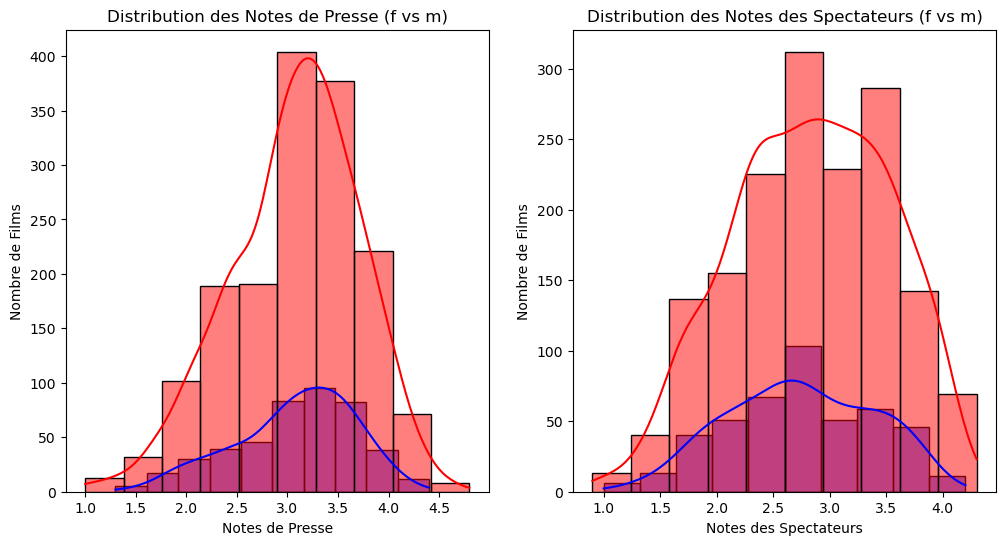

In [ ]:
histogramme_categorie_de_film(base_cnc_agregee, "genre_ind", "f", "m")

# + ajouter Anova

### Je croise le genre et le type de devis

A priori, les spectateurs seraient plus sexistes que la presse. Même si, on peut noter que les résultats ne sont pas flagrants (à part, encore et toujours cette différence criante entre nombre de films produits par des réalisateurs et nombre de films produits par des réalisatrices). Dans un second temps, je vais essayer de comparer quelques grands journaux français. D'une part, nous nous intéressons à la critique de presse écrite « intellectuelle », dans laquelle nous classons Télérama, Le Monde, Libération, Les Inrockuptibles, Les Cahiers du Cinéma et Positif. Nous les distinguons de la critique de presse écrite « commerciale », comprenant Le Parisien, Première et Studio Ciné Live.

In [27]:
#Comparaison avis spectateurs vs presse selon le type de devis
base_cnc_agregee_moyennes = base_cnc_agregee.groupby("type_de_devis").agg(
    presse=('press_rating', "mean"),
    spectateur=('spectators_rating', "mean")
).reset_index()
base_cnc_agregee_moyennes

/tmp/ipykernel_95079/4065481263.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_cnc_agregee_moyennes = base_cnc_agregee.groupby(


,type_de_devis,genre_ind,presse,spectateur
0,<2 m,f,3.107429,2.722857
1,<2 m,"f,m",2.964286,2.735714
2,<2 m,f_coréalisé,3.376190,3.066667
3,<2 m,m,3.109533,2.825486
4,<2 m,"m,f",3.050000,2.925000
5,<2 m,m_coréalisé,3.083721,2.920930
6,<2 m,non trouvé,3.133040,2.974009
7,entre 2 et 4 m,f,3.146957,2.740000
8,entre 2 et 4 m,"f,m",3.340000,2.780000
9,entre 2 et 4 m,f_coréalisé,3.195238,2.876190


In [ ]:
histogramme_genre_film(base_cnc_agregee, "Action", "Policier")

ValueError: cannot reindex on an axis with duplicate labels

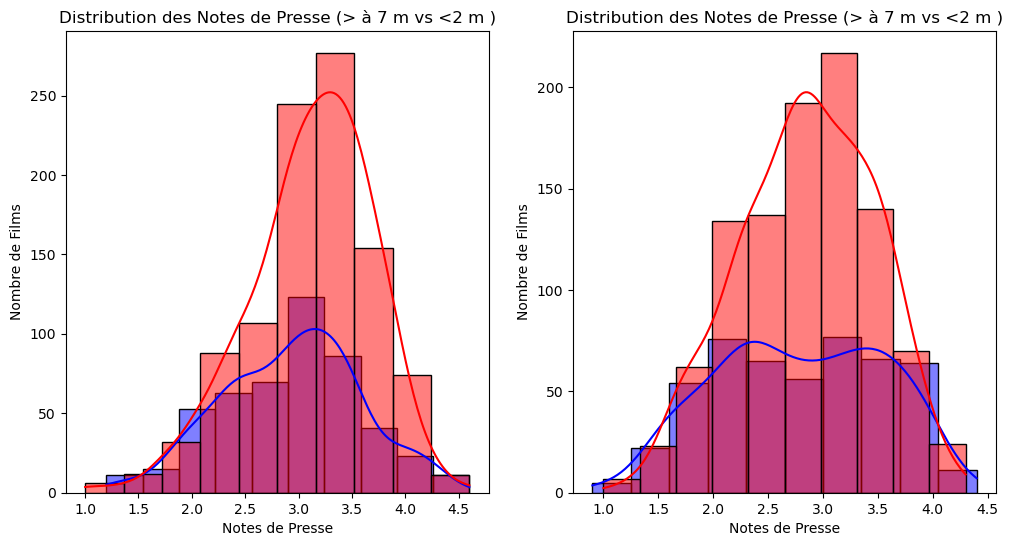

In [ ]:


def histogramme_devis(dataframe, categorie1, categorie2) : 
 fig, axes = plt.subplots(1,2, figsize=(12, 6))

 dataframe = dataframe[dataframe['type_de_devis'].isin([categorie1, categorie2])]
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie1], x='press_rating', color='blue', kde=True, stat='count', label=categorie1, bins=10, alpha=0.5, ax = axes[0])
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie2], x='press_rating', color='red', kde=True, stat='count', label=categorie2, bins=10, alpha=0.5, ax = axes[0])

 axes[0].set_title(f'Distribution des Notes de Presse ({categorie1} vs {categorie2})')
 axes[0].set_xlabel('Notes de Presse')
 axes[0].set_ylabel('Nombre de Films')
#  axes[0].set_legend(title='Type de Devis')


 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie1], x='spectators_rating', color='blue', kde=True, stat='count', label=categorie1, bins=10, alpha=0.5, ax = axes[1])
 sns.histplot(dataframe[dataframe["type_de_devis"]== categorie2], x='spectators_rating', color='red', kde=True, stat='count', label=categorie2, bins=10, alpha=0.5, ax = axes[1])

 axes[1].set_title(f'Distribution des Notes de Presse ({categorie1} vs {categorie2})')
 axes[1].set_xlabel('Notes de Presse')
 axes[1].set_ylabel('Nombre de Films')
#  axes[1].set_legend(title='Type de Devis')


histogramme_devis(base_cnc_agregee, "> à 7 m", "<2 m " )



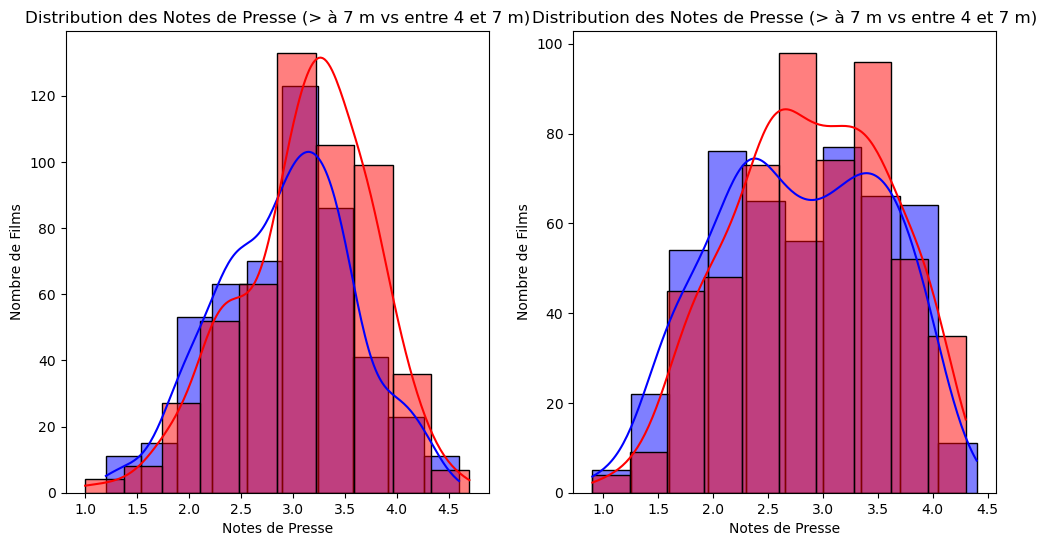

In [ ]:
histogramme_devis(base_cnc_agregee, "> à 7 m", "entre 4 et 7 m" )

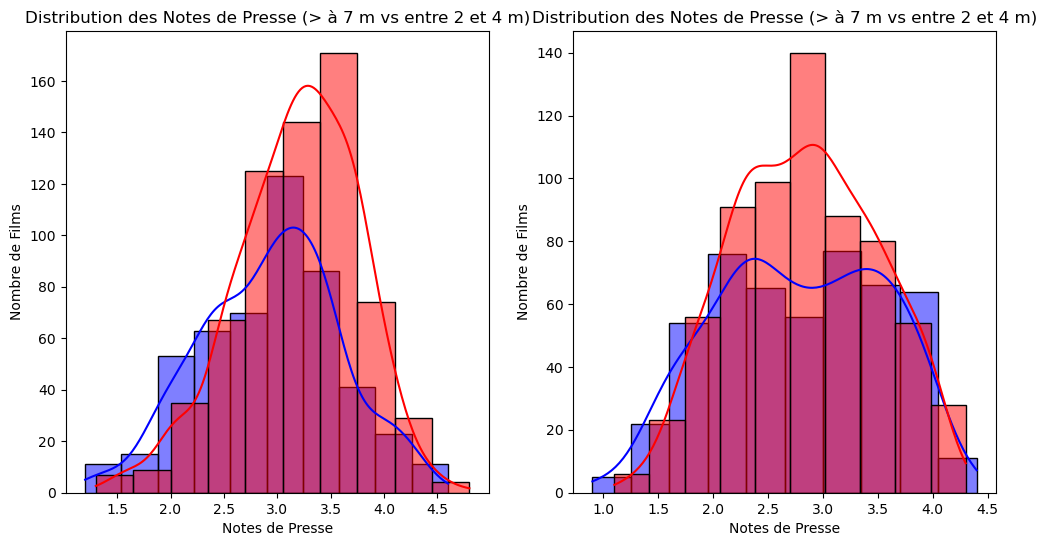

In [ ]:
histogramme_devis(base_cnc_agregee, "> à 7 m", "entre 2 et 4 m" )

In [ ]:
#Comparaison avis spectateurs vs presse selon le type de devis et le genre
base_cnc_agregee_moyennes = base_cnc_agregee.groupby(
    ["type_de_devis", "genre_ind"]
).agg(
    presse=('press_rating', "mean"),
    spectateur=('spectators_rating', "mean")
).reset_index()
base_cnc_agregee_moyennes

KeyError: 'genre_ind'

Le résultat des notes n'est pas incroyable. En tout cas, elles ne semblent rien dire sur une réception différenciée des films réalisés par des femmes, par opposition à des films réalisés par des hommes... Ainsi peut-on conclure que la critique n'est pas sexiste ?

In [ ]:
base_cnc_agregee_f = base_cnc_agregee.query("genre_ind == 'f'")
base_cnc_agregee_f

,visa,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,date_sortie_bluray,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa
0,117042,BYE BYE BLONDIE,[DESPENTES Virginie],MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,...,-,21/07/2012,Long métrage,4 500 000 EUR,Français,"35mm, Super 8",Couleur,Dolby Digital,1.85 : 1,117042
22,149287,Une fille facile,[ZLOTOWSKI Rebecca],LES FILMS VELVET,2684638.0,Fiction,OUI,3,None,[C+],...,21/01/2020,14/01/2020,Long métrage,-,Français,-,Couleur,-,-,149287
28,142598,Moutonnière (La),[DJAMA Sofia],LIAISON CINEMATOGRAPHIQUE,1152380.0,Fiction,OUI,1,avant,[Ciné+],...,-,24/04/2018,Long métrage,-,ARABIC,-,Couleur,-,-,142598
33,133830,ABUS DE FAIBLESSE,[BREILLAT Catherine],ARTE FRANCE CINEMA / CB FILMS / FLACH FILM / F...,3984660.0,Fiction,None,3,avant,None,...,-,03/09/2014,Long métrage,-,Français,-,Couleur,-,-,133830
39,131183,DARK TOUCH,[DE VAN Marina],EX NIHILO,2729542.0,Fiction,None,3,None,None,...,-,01/03/2020,Long métrage,2 729 542 EUR,Anglais,-,Couleur,-,-,131183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,151976,A la folie,[ESTROUGO Audrey],DAMNED FILMS,148741.0,Fiction,OUI,3,après,None,...,-,06/08/2022,Long métrage,-,Français,-,Couleur,-,-,151976
2147,152335,Amours d'Anaïs (Les),[BOURGEOIS-TACQUET Charline],LFP - LES FILMS PELLÉAS,3098451.0,Fiction,OUI,1,avant,"[C+, Ciné+]",...,-,13/12/2021,Long métrage,-,Français,-,Couleur,-,-,152335
2153,153199,Portrait d'une jeune fille qui va bien,[KIBERLAIN Sandrine],CURIOSA FILMS / E.D.I FILMS,3732502.0,Fiction,OUI,1,None,"[C+, Ciné+]",...,07/06/2022,06/06/2022,Long métrage,-,Français,-,Couleur,-,-,153199
2157,151526,Parent d'élève,[SAGLIO Noémie],RECTANGLE PRODUCTIONS,4625760.0,Fiction,OUI,3,None,"[C+, Ciné+]",...,-,10/02/2021,Long métrage,-,Français,-,Couleur,-,-,151526


In [ ]:
#Je regarde la différence de notation selon le genre du film, le genre du réal

classement_genres_preferes(base_cnc_agregee_f, 'spectateur')

ValueError: Grouper for 'genre' not 1-dimensional

In [ ]:
presse.head()
base_cnc_agregee_presse = pd.merge(base_cnc_agregee, presse,left_on='identifiant', right_on='identifiant', how='inner')

## III - Modelisation

### 1) Peut-on prédire les notes des **spectateurs** à partir de caractéristiques des films ?

La première analyse descriptive montre que l'on distingue différents facteurs qui pourraient expliquer des différentes notes attribuées par les spectateurs. Nous pouvons voir si un modèle permettrait d'expliquer et prédire les notes des spectateurs en se basant sur divers critères, tels que le genre, la durée ou encore les récompenses obtenus.  

In [12]:
# Suppression des lignes qui n'ont pas de durée renseignée (seulement 24 sur les 10837 films)
table_regression = table_films.dropna(subset=['duration_min'])

# Filtrage poru ne conserver que les modalités de genre de films présentes plus de 50 fois 
modalites_conservees = classement_genres_preferes(table_regression, 'spectators_rating').index.tolist()
table_regression = table_regression[table_regression['genre1'].isin(modalites_conservees)]

In [15]:
# test de normalité de la distribution des notes
stat, p_value = shapiro(table_films['spectators_rating'])
print('p-value :', p_value)

p-value : 2.6021836323601493e-31


La très faible p-value montre que nous pouvons fortement rejeter l'hypothèse de normalité des données. La regression se fera ainsi avec la normalisation des notes au préalable. 

MSE : 0.3673
R² : 0.1950

ATTENTION : les coefficients sont ceux de la régression avec les notes normalisées.

              Variable  Coefficient  Lower CI  Upper CI
0            Animation     0.811082  0.690008  0.932157
12                prix     0.553885  0.500058  0.607712
2               Biopic     0.549177  0.416012  0.682342
1             Aventure     0.309898  0.198051  0.421745
5                Drame     0.294323  0.216564  0.372082
15        duration_min     0.210884  0.189717  0.232050
8             Policier     0.151981  0.016273  0.287690
4   Comédie dramatique     0.136580  0.037063  0.236097
11         nominations     0.127000  0.070529  0.183471
13                 f,m    -0.005163 -0.112924  0.102597
14                   m    -0.053141 -0.096713 -0.009570
10            Thriller    -0.084833 -0.234912  0.065246
9      Science Fiction    -0.151817 -0.479129  0.175495
3              Comédie    -0.201872 -0.285391 -0.118354
6    Epouvante-horreur    -0.445212 -0.590536 -0.

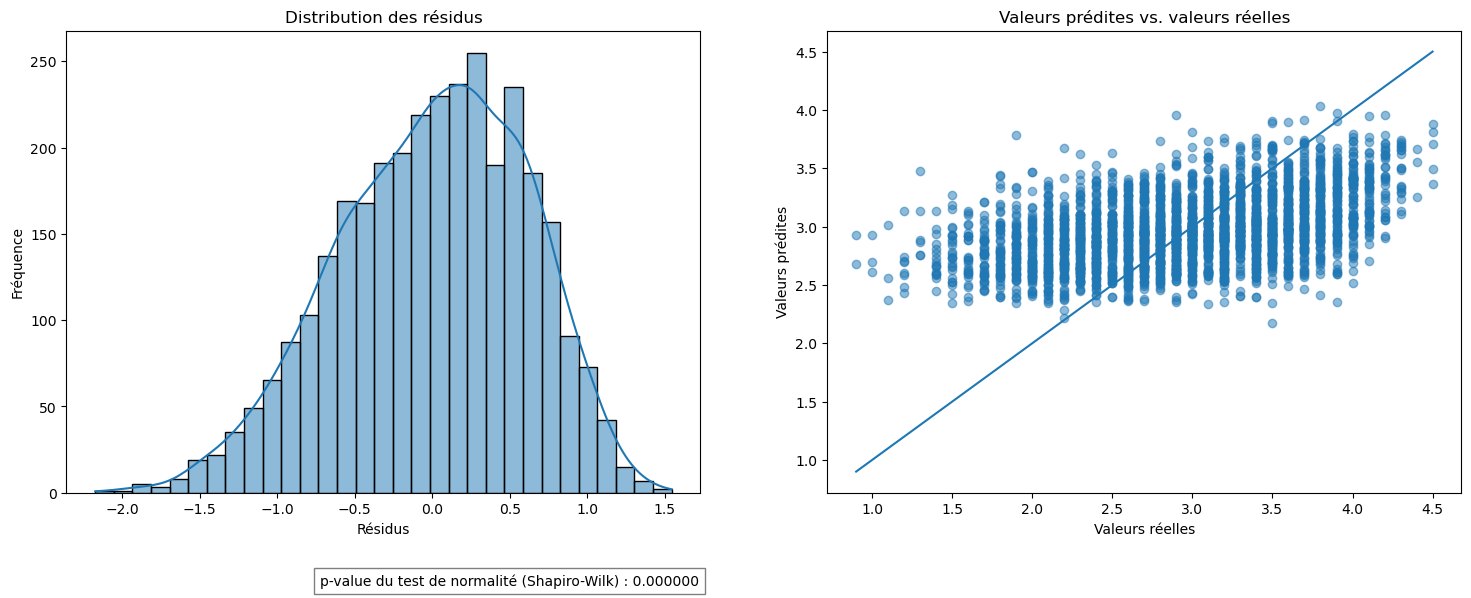

In [16]:
regression(table_regression)

Afin de gérer les variables discrètes, dans la regression chaque modalité fait l'objet d'une variable binaire. Les modalités de références (utilisées comme base de comparaison, non présentes, elles n'ont pas de coefficients afin de ne pas avoir de problème de multicolinéarité) sont :
genre **Action**, avoir une réalisatrice **f**, avoir reçu une/des **nominations**.
Les **coefficients** de la régression (coefficients avec variable cible normalisée), montrent que : 
- Certains coefficients ne sont pas statistiquement significatifs (leur intervalles de confiance à 95% incluent 0) : *Ex : Le fait d'être un Thriller par rapport à Action*
- Certains coefficients sont statistiquement significatifs mais ont un poids assez faible : *Ex : Le fait d'avoir un réalisateur par rapport à une réalisatrice*
- Les coefficients qui semblent avoir la plus grande importance concernent :
    - Les genres  **Animation, Biopic** semblent avoir un impact positif significativement plus grand sur les notes par rapport au genre de référence Action. Idem pour les genres       **Epouvante-horreur, et Fantastique** mais négativement.
    - Le fait d'avoir reçu un **prix**, semblent avoir un impact positif significativement plus grand sur les notes par rapport au fait d'avoir reçu au moins une nomination.

Les **métriques** du modèle, nous donnent d'autres informations :

- La **MSE** (erreur quadratique moyenne) de 0.367 (pour des notes (variable cible) comprises entre 1 et 5) montre que les erreurs de prédiction sont relativement faibles : En moyenne, les notes prédites sont à environ 0.367 unités de leur valeur réelle. 

- Cependant avec un **R²** (proportion de la variance des notes des spectateurs expliquée par les variables du modèle) relativement faible, de 0.195, indique que seulement environ 19.5% de la variance des notes est expliquée par le modèle. 


Cette situation avec une plutôt bonne MSE mais un R² assez faible, pourrait s'expliquer par une **faible variabilité des notes autour de leurs moyennes** (Cf Premiers histogrammes de la partie II Analyses descriptives). Enraînant mécaniquement de **Relativement bons résultats en MSE**. Les valeurs prédites sont ainsi toutes très proches (comprises principalement dans l'interval [2.2, 3.7]) comme visible sur le graphique **Valeurs prédites vs valeurs réelles**.
Cependant ce modèle n'explique par la variabilité des données d'où un **faible R²**. 


De ce fait nous ne pouvons pas dire que ce modèle soit très pertinent.


### 2) Peut-on regrouper les **presses** en fonction de leurs appréciations aux divers films ?
Concernant la presse, et au vue des résultats nous pouvons nous demander si on ne pourrait pas identifier des groupe de presse en fonction de leur notes attribuées en fonction des films.


In [17]:
# Mise en forme de la table qui sera utilisée pour le clustering : calcul pour chaque presse des notes attribuées pour genre de film et genre du réalisateur.
table_cluster = get_table_cluster(table_films, presse_notes)

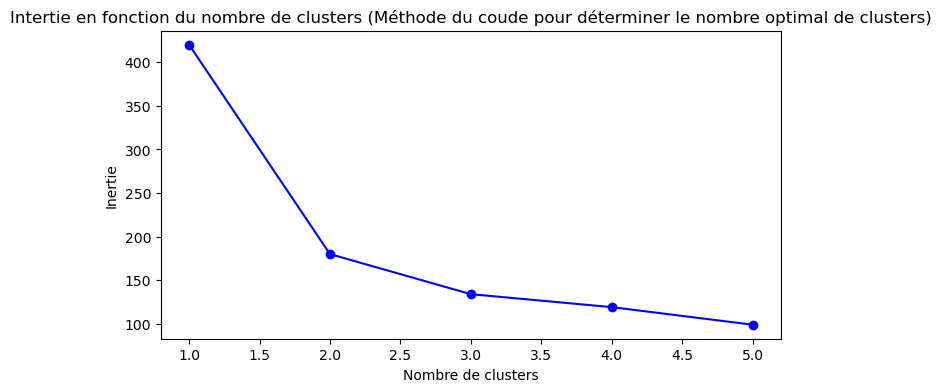

Graphiquement le nombre optimal de clusters est : 2


In [18]:
# Recherche du nombre de clusters optimals (en se limitant à 5)
nb_clusters_optimal = determine_optimal_clusters(table_cluster, 5)

In [19]:
# clustering par méthode K-means avec 2 clusters :
clusters = clustering_K_means(table_cluster,2)

# Visualisation des moyennes des différentes variables étudiées en fonction des groupes.
table_cluster.groupby('Cluster').mean().round(2)

,f,"f,m",m,Action,Animation,Aventure,Biopic,Comédie,Comédie dramatique,Drame,Epouvante-horreur,Fantastique,Policier,Science Fiction,Thriller
Cluster,,,,,,,,,,,,,,,
0,3.73,3.70,3.73,3.42,4.02,3.75,3.80,3.67,3.75,3.84,3.56,3.42,3.80,3.57,3.57
1,3.16,3.19,3.13,2.86,3.53,3.16,3.35,2.99,3.23,3.30,2.78,2.95,3.19,3.00,2.96


Nous pouvons à présent regarder quelles presses sont mises ensemble, ainsi que les moyennes des notes attribuées aux films, selon divers critères, au sein de chaque groupe (cluster).

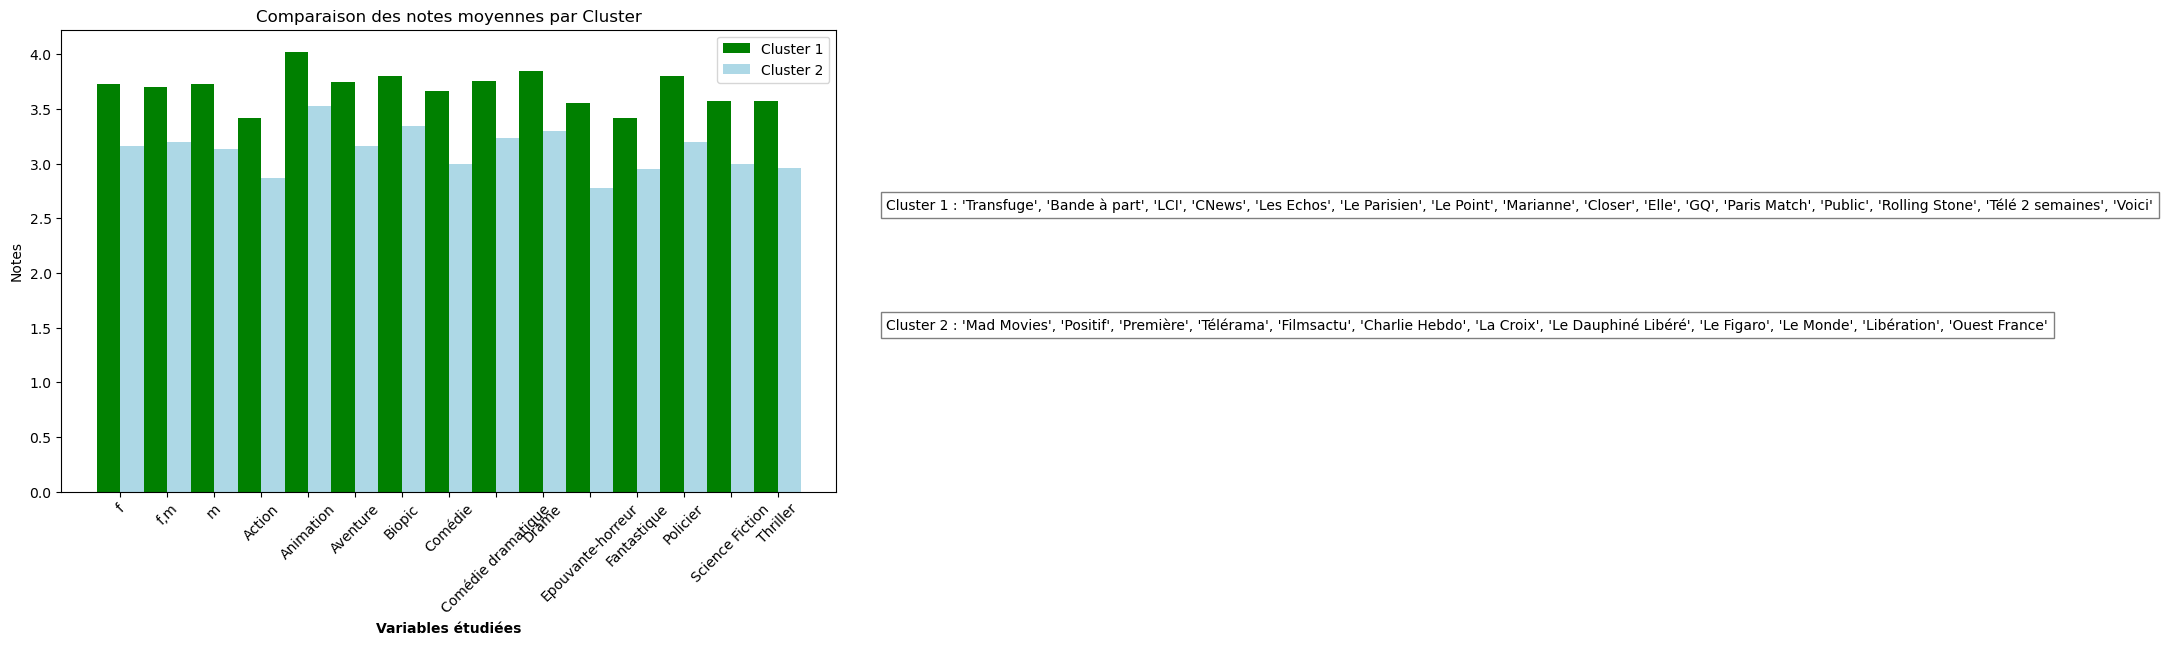

In [20]:
graphe_cluster(table_cluster)

Le Cluster 1 est composé de presse qui donnent globalement les notes les plus élevées.
======== blablabla
